In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from utils import *
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds

### Preprocess Data

Text(0.5, 0, 'Date')

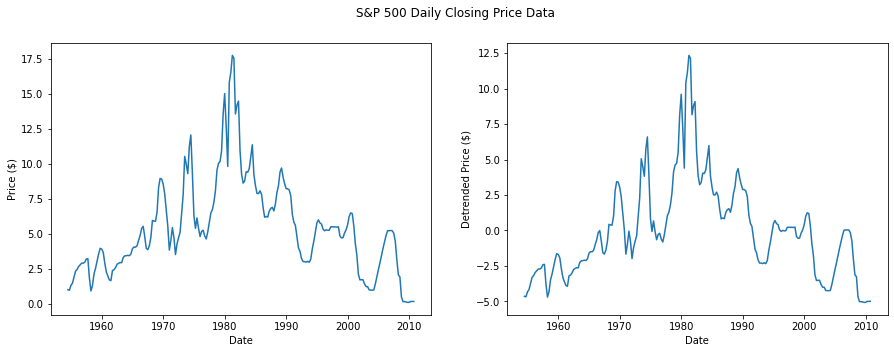

In [2]:
# Read data
y_orig = pd.Series(fedfunds, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"))
# Detrend data
y_detr = pd.Series(signal.detrend(y_orig), index=y_orig.index)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('S&P 500 Daily Closing Price Data')
ax1.plot(y_orig)
ax1.set_ylabel('Price ($)')
ax1.set_xlabel('Date')
ax2.plot(y_detr)
ax2.set_ylabel('Detrended Price ($)')
ax2.set_xlabel('Date')

x, y_detr = preprocess_ts(y_detr, lags=2)

### Bayesian Parameter Estimation (Lim et al., 2021)

In [5]:
params = {'num_states': 2,
          'sig0': 1,
          'sig1': 3,
          'p': 0.95,
          'q': 0.95,
          'd0': 1 ,
          'v0': 1,
          'u00': 5, #p11 ~ D(u00,u01)
          'u01': 5,
          'u11': 5, #p11 ~ D(u11,u10)
          'u10': 5,
          'reps': 5000
        }

burnin = 1000

out1, out2, out3 = estimate(x, y_detr, **params)

 18%|█▊        | 894/5000 [00:34<02:39, 25.81it/s]/Users/lorenzoflores/Documents/GitHub/bayes-for-markov-switching/utils.py:40: RuntimeWarning: invalid value encountered in true_divide
  ett11 = ett11/fit
/Users/lorenzoflores/Documents/GitHub/bayes-for-markov-switching/utils.py:42: RuntimeWarning: divide by zero encountered in log
  total_likelihood += np.log(fit)
100%|██████████| 5000/5000 [03:16<00:00, 25.41it/s]


Text(0.5, 1.0, 'Probability of State 1')

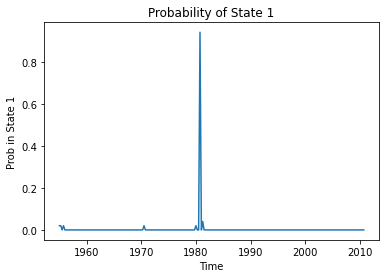

In [30]:
# Plot probability across states
S = pd.Series(np.vstack(out1).mean(axis=0), index=y_orig.index[2:])
p00, p01, p10, p11 = list(np.stack(out2).reshape(50, -1).mean(axis=0))
plt.plot(S)
plt.xlabel('Time')
plt.ylabel('Prob in State 1')
plt.title(f"Probability of State 1")

In [10]:
# Collect parameters
final_params = {'phi0':[], 'phi1':[], 'sigma0':[], 'sigma1':[], 'mu':[]}
for d in out3:
    for key in d:
        final_params[key].append(d[key])
for key in final_params:
    out_matrix = np.vstack([i.reshape(-1) for i in final_params[key]])
    print(f"{key}: {', '.join([f'{round(m,3)} ({round(s,3)})' for (m,s) in zip(out_matrix.mean(axis=0), out_matrix.std(axis=0))])}")
    

phi0: 1.334 (0.103), -0.403 (0.102), 0.013 (0.013)
phi1: -0.65 (7.938), -0.758 (7.344), 0.897 (7.097)
sigma0: 0.006 (0.001)
sigma1: 39.525 (109.615)
mu: 0.082 (0.115), 0.165 (1.711)


### Comparison to `statsmodels`

In [11]:
import statsmodels.api as sm

In [12]:
num_lags = 2
mod_fedfunds = sm.tsa.MarkovRegression(y_detr, k_regimes=2, exog=x, switching_variance=True)
res_fedfunds = mod_fedfunds.fit()

Text(0.5, 1.0, 'Probability of State 1')

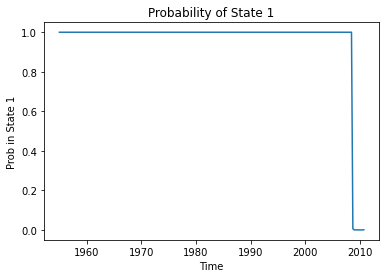

In [31]:
sm_probs = res_fedfunds.smoothed_marginal_probabilities.values[:,1]
plt.plot(pd.Series(sm_probs, index=y_orig.index[-len(sm_probs):]))
plt.xlabel('Time')
plt.ylabel('Prob in State 1')
plt.title(f"Probability of State 1")

In [29]:
res_fedfunds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  224
Model:               MarkovRegression   Log Likelihood                 373.386
Date:                Sun, 04 Dec 2022   AIC                           -722.772
Time:                        12:56:43   BIC                           -681.833
Sample:                             0   HQIC                          -706.247
                                - 224                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.228      0.000       0.001       0.002
x1             0.2332      0.025      9.256      0.000       0.184       0.283
x2            -0.0412      0.018     -2.238      0.025      -0.077      -0.005
x3             0.0012      0.000      4.228      0.000       0.001       0.002
sigma2       1.95e-06   9.49e-07      2.056      0.040    9.11e-08    3.81e-06
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.003      2.476      0.013       0.002       0.015
x1             1.2166      0.066     18.529      0.000       1.088       1.345
x2            -0.2699      0.065     -4.121      0.000      -0.398      -0.142
x3             0.0083      0.003      2.476      0.013       0.002       0.015
sigma2         0.0026      0.000     10.368      0.000       0.002       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9799      0.038     26.002      0.000       0.906       1.054
p[1->0]        0.0039      0.004      0.957      0.339      -0.004       0.012
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.39e+18. Standard errors may be unstable.
"""